# Distance comparison

In [8]:
cd ..

/home/tristan/research/ot_markov_distances


In [11]:
import logging
import os
import sys
import warnings
from time import perf_counter
def append_path(s):
    if s in sys.path:
        return
    sys.path.append(s)
    
#You don’t need those lines if you installed the packages
append_path("/home/tristan/research/ot_markov_distances/")
append_path("/home/tristan/research/tb_ml/")
append_path("/home/tristan/research/FGW/lib")

sys.path.pop(sys.path.index("/home/tristan/research/ot_markov_distances/experiments")) 
# the FGW code handles imports badly (they’re not packaged up), so we need to remove our own utils from
# the path

logging.basicConfig(level=logging.WARNING, force=True)

In [1]:
import torch
import networkx as nx
import numpy as np
from numpy.random import default_rng
from tqdm.notebook import tqdm, trange
rng=default_rng()

In [2]:
import matplotlib.pyplot as plt

In [5]:
import logging; logging.basicConfig(level=logging.WARNING, force=True)

In [12]:
#our imports
from experiments.utils.modules import ParametricMarkovMatrixWithMatchings
from experiments.utils.data_generation import circle_graph, FGW_build_noisy_circular_graph, add_er_noise, get_label_matrix
from ot_markov_distances.discounted_wl import discounted_wl_infty as wl_reg_infty
from ot_markov_distances.utils import weighted_transition_matrix

#fgw imports
from ot_distances import  Fused_Gromov_Wasserstein_distance #this is FGW code. 
from graph import Graph as FGW_Graph



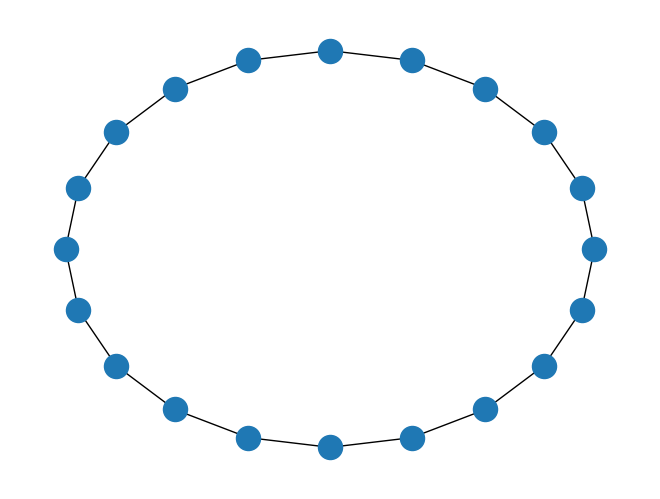

In [13]:
circle_graph = FGW_build_noisy_circular_graph(20)
pos = nx.circular_layout(circle_graph)
nx.draw(circle_graph, pos)

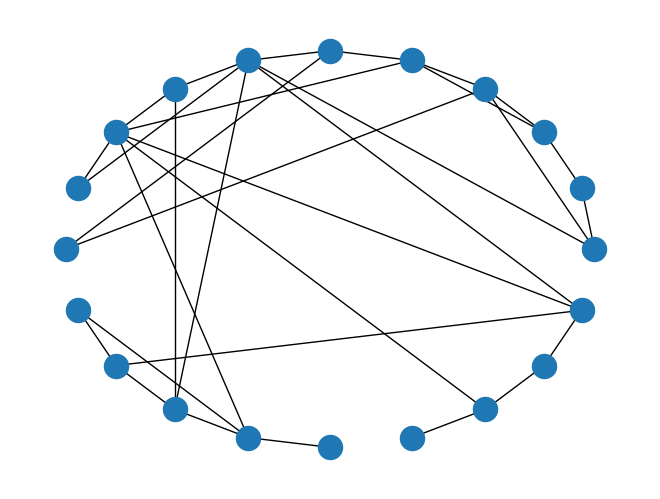

In [14]:
noisy_circle = add_er_noise(circle_graph, .1)
nx.draw(noisy_circle, pos)

In [15]:
noisy_circle = add_er_noise(circle_graph, .01)
device = torch.device("cuda:2")
FGW = Fused_Gromov_Wasserstein_distance()

def fgw_graphs(G1, G2):
    return FGW.graph_d(FGW_Graph(G1), FGW_Graph(G2))

def wl_graphs(G1, G2, delta=.5):
    with torch.no_grad():
        n1 = len(G1)
        n2 = len(G2)
        l1 = get_label_matrix(G1).to(device)
        l2 = get_label_matrix(G2).to(device)
        
        M1 = weighted_transition_matrix(G1, q=.1).to(device)
        M2 = weighted_transition_matrix(G2, q=.1).to(device)
        d1 = torch.ones((n1,), device=device) / n1
        d2 = torch.ones((n2,), device=device) / n2

        D = (l1[:, None, :] - l2[None, :, :]).square().sum(-1)
        return wl_reg_infty(M1[None, ...], M2[None, ...], 
                            D[None, ...],  d1[None, ...], d2[None, ...], delta=delta, sinkhorn_reg=.001).item()
fgw_graphs(circle_graph, circle_graph)
wl_graphs(circle_graph, circle_graph)

0.003944416530430317

In [16]:
delta_values = [.05, .1, .25, .5]
wl_distances = []
fgw_distances = []
noise_values = [0, *(2 ** i for i in [-6, -5, -4, -3, -2.5, -2, -1.5, -1, -.5, 0] )]
n_samples = 500

for p in noise_values:
    
    wl_distance_samples = [[] for _ in delta_values]
    fgw_distance_samples = []
    
    for _ in trange(n_samples):
        
        test_graph = circle_graph
        test_noisy_graph = add_er_noise(test_graph, p=p)
        
        fgw_distance_samples.append(fgw_graphs(test_graph, test_noisy_graph))
        for delta, s in zip(delta_values, wl_distance_samples):
            s.append(wl_graphs(test_graph, test_noisy_graph, delta=delta))       
        
        
    wl_distances.append(wl_distance_samples)
    fgw_distances.append(fgw_distance_samples)
    

  0%|          | 0/500 [00:00<?, ?it/s]

/home/tristan/research/ot_markov_distances/ot_markov_distances/discounted_wl.py:210: UserWarning: regularized WL did not converge
  warnings.warn("regularized WL did not converge")


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [112]:
wl_distances_average = [np.mean(samples) for samples in wl_distances]
fgw_distances_average = [np.mean(samples) for samples in fgw_distances]



In [113]:
%store wl_distances_array
%store fgw_distances

Stored 'wl_distances_array' (ndarray)
Stored 'fgw_distances' (list)


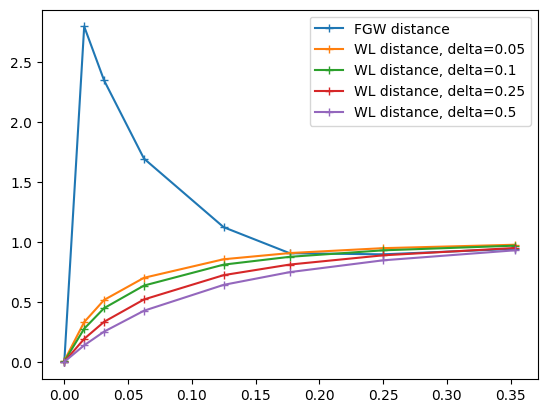

In [114]:
plt.plot(noise_values[:-3], fgw_distances_average[:-3] / fgw_distances_average[-3], marker="+", label="FGW distance")

wl_distances_array = np.asarray(wl_distances)

for i, delta_value in enumerate(delta_values):
    averages = wl_distances_array[:, i, :].mean(-1)
    plt.plot(noise_values[:-3], averages[:-3]  / averages[-3], marker="+", label=f"WL distance, delta={delta_value}")
plt.legend()
##plt.xscale("log")